This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Recipe #1: Clutter and attenuation correction plus composition for two DWD radars

This recipe shows a workflow to process radar data provided by the German Weather Service (DWD). The processing includes: 

- *(1)* Reading local [DX-Data](../fileio/wradlib_radar_formats.ipynb#German-Weather-Service:-DX-format) for radars Feldberg and Tuerkheim. 
- *(2)* Clutter correction using the [Gabella filter algorithm](https://docs.wradlib.org/en/latest/clutter.html). 
- *(3)* Attenuation correction using the [modified Kraemer algorithm](https://docs.wradlib.org/en/latest/atten.html). 
- *(4)* Conversion from reflectivity to rainfall using the [Z-R Conversions](https://docs.wradlib.org/en/latest/zr.html) module. 
- *(5)* Accumulation of rainfall depths over the entire event. 
- *(6)* [Composition](https://docs.wradlib.org/en/latest/comp.html) of data from both radars to a common Cartesian grid (UTM Zone 32). Composition is based on a weighted combination, using the sampling volume as a [quality criterion](https://docs.wradlib.org/en/latest/qual.html) 
- *(7)* Plotting a rainfall map using [cartesian_plot](https://docs.wradlib.org/en/latest/vis.html)

In [1]:
import wradlib as wrl
import matplotlib.pyplot as pl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

In [2]:
import glob
import os
def process_polar_level_data(radarname):
    """Reading and processing polar level data (DX) for radar <radarname>
    """
    print("Polar level processing for radar %s..." % radarname)
    # preparations for loading sample data in source directory
    files = glob.glob(os.path.join(wrl.util.get_wradlib_data_path(),
                                   'dx/recipe1_data/raa*%s*bin' % radarname))

    if len(files) == 0:
        print("WARNING: No data files found - maybe you did not extract "
              "the data from data/recipe1_data.zip?")
    data = np.empty((len(files), 360, 128))
    # loading the data (two hours of 5-minute images)
    for i, f in enumerate(files):
        #print(i, f)
        data[i], attrs = wrl.io.read_dx(f)
    # Clutter filter on an event base
    clmap = wrl.clutter.filter_gabella(data.mean(axis=0), tr1=12, n_p=6,
                                       tr2=1.1)
    for i, scan in enumerate(data):
        data[i] = wrl.ipol.interpolate_polar(scan, clmap)
    # correcting for attenuation
    pia = wrl.atten.correct_attenuation_constrained(
        data,
        a_max=1.67e-4,
        a_min=2.33e-5,
        n_a=100,
        b_max=0.7,
        b_min=0.65,
        n_b=6,
        gate_length=1.,
        constraints=[wrl.atten.constraint_dbz, 
                     wrl.atten.constraint_pia], 
        constraint_args=[[59.0],[10.0]])
    data = data + pia
    # converting to precipitation depth
    R = wrl.zr.z_to_r(wrl.trafo.idecibel(data), a=256, b=1.4)
    depth = wrl.trafo.r_to_depth(R, 300.)
    # calculate hourly accumulation
    accum = depth.sum(axis=0)

    return accum

In [3]:
def bbox(*args):
    """Get bounding box from a set of radar bin coordinates
    """
    x = np.array([])
    y = np.array([])
    for arg in args:
        x = np.append(x, arg[:, 0])
        y = np.append(y, arg[:, 1])
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    return xmin, xmax, ymin, ymax


In [4]:
import zipfile
import shutil
import datetime as dt

# set timer
start = dt.datetime.now()
# unzip data
filename = wrl.util.get_wradlib_data_file('dx/recipe1_data.zip')
targetdir = wrl.util.get_wradlib_data_path() + '/dx/recipe1_data'
with zipfile.ZipFile(filename, 'r') as z:
    z.extractall(targetdir)

# set scan geometry and radar coordinates
r = np.arange(500., 128500., 1000.)
az = np.arange(0, 360)
tur_sitecoords = (9.7839, 48.5861)
fbg_sitecoords = (8.005, 47.8744)

# processing polar level radar data
#   Tuerkheim
tur_accum = process_polar_level_data("tur")
#   Feldberg
fbg_accum = process_polar_level_data("fbg")

# remove unzipped files
if os.path.exists(targetdir):
    try:
        shutil.rmtree(targetdir)
    except Exception:
        print("WARNING: Could not remove directory data/recipe1_data")

# derive UTM Zone 32 coordinates of range-bin centroids
# create osr projection using epsg number for UTM Zone 32
proj_utm = wrl.georef.epsg_to_osr(32632)

#  for Tuerkheim radar
tur_coord = wrl.georef.spherical_to_centroids(r, az, 0, tur_sitecoords, 
                                              proj=proj_utm)
tur_coord = tur_coord[..., 0:2]
tur_coord = tur_coord.reshape(-1, tur_coord.shape[-1])

# for Feldberg radar
fbg_coord = wrl.georef.spherical_to_centroids(r, az, 0, fbg_sitecoords,
                                              proj=proj_utm)
fbg_coord = fbg_coord[..., 0:2]
fbg_coord = fbg_coord.reshape(-1, fbg_coord.shape[-1])

# define target grid for composition
xmin, xmax, ymin, ymax = bbox(tur_coord, fbg_coord)
x = np.linspace(xmin, xmax + 1000., 1000)
y = np.linspace(ymin, ymax + 1000., 1000)
grid_coords = wrl.util.gridaspoints(y, x)

# derive quality information - in this case, the pulse volume
pulse_volumes = np.tile(wrl.qual.pulse_volume(r, 1000., 1.), 360)
# interpolate polar radar-data and quality data to the grid
print("Gridding Tuerkheim data...")
tur_quality_gridded = wrl.comp.togrid(tur_coord, grid_coords,
                                      r.max() + 500.,
                                      tur_coord.mean(axis=0),
                                      pulse_volumes,
                                      wrl.ipol.Nearest)
tur_gridded = wrl.comp.togrid(tur_coord, grid_coords, r.max() + 500.,
                              tur_coord.mean(axis=0),
                              tur_accum.ravel(),
                              wrl.ipol.Nearest)

print("Gridding Feldberg data...")
fbg_quality_gridded = wrl.comp.togrid(fbg_coord, grid_coords,
                                      r.max() + 500.,
                                      fbg_coord.mean(axis=0),
                                      pulse_volumes,
                                      wrl.ipol.Nearest)
fbg_gridded = wrl.comp.togrid(fbg_coord, grid_coords, r.max() + 500.,
                              fbg_coord.mean(axis=0),
                              fbg_accum.ravel(),
                              wrl.ipol.Nearest)

# compose the both radar-data based on the quality information
# calculated above
print("Composing Tuerkheim and Feldbarg data on a common grid...")
composite = wrl.comp.compose_weighted([tur_gridded, fbg_gridded],
                                      [1. / (tur_quality_gridded + 0.001),
                                       1. / (fbg_quality_gridded + 0.001)])
composite = np.ma.masked_invalid(composite)

print("Processing took:", dt.datetime.now() - start)

Polar level processing for radar tur...


Polar level processing for radar fbg...


Gridding Tuerkheim data...


Gridding Feldberg data...


Composing Tuerkheim and Feldbarg data on a common grid...
Processing took: 0:00:13.068088


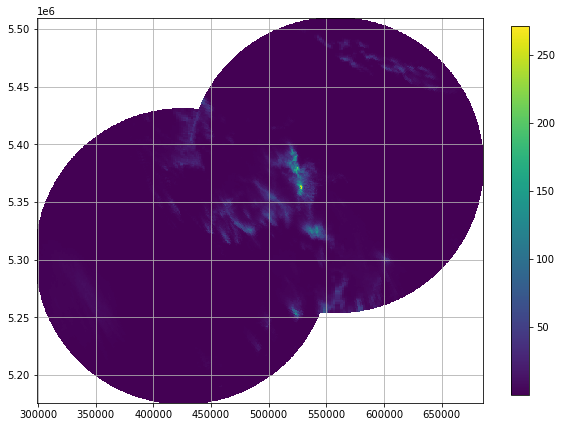

In [5]:
# Plotting rainfall map
pl.figure(figsize=(10,8))
pl.subplot(111, aspect="equal")
pm = pl.pcolormesh(x, y, composite.reshape((len(x), len(y))),
                   cmap="viridis")
pl.grid()
pl.xlim(min(x), max(x))
pl.ylim(min(y), max(y))
pl.colorbar(pm, shrink=0.85)

Download required data at the [wradlib-data repository](https://github.com/wradlib/wradlib-data/archive/master.zip).

<div class="alert alert-info">

**Note** <br>

In order to run the recipe code, you need to extract the sample data into a directory pointed to by environment variable ``WRADLIB_DATA``.
</div>